In [1]:
# import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from math import comb

import wecopttool as wot
from wecopttool.waves import jonswap_spectrum as js
from wecopttool.waves import long_crested_wave as lcw
from wecopttool.waves import omnidirectional_spectrum

import os
import Pioneer_Inverted_Pendulum as pip
from scipy.optimize import Bounds

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

wot.set_loglevel('ERROR', capytaine=False)
data_path = os.path.join('pioneer_data')

In [2]:
wavefreq = 0.375
f1 = wavefreq
nfreq = 5
amplitude = 0.2

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)

In [3]:


cntrl_type = 'PI'
NPIP = pip.NonlinearInvertedPendulumPTO(f1, nfreq, ndof = 1, control_type = cntrl_type)



LinPIP = pip.LinearizedInvertedPendulumPTO(f1, nfreq, ndof = 1, control_type = cntrl_type)
wec_lin = pip.PioneerBuoy.from_empirical_data(f1, nfreq, f_add = LinPIP.f_add, constraints = LinPIP.constraints)  
wec_nl = pip.PioneerBuoy.from_empirical_data(f1, nfreq, f_add = NPIP.f_add, constraints = NPIP.constraints)
res_lin = LinPIP.solve(wec_lin, waves)
x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)
res_nl = NPIP.solve(wec_nl, waves, x_wec_0, x_opt_0)


Linearized wave 0, exit mode: 0, nit: 31, cntr: PI, avg. power: -23.92W
NonLin wave 0, exit mode: 0, nit: 19, cntr: PI, avg. power: -19.16W


In [4]:
nsubsteps = 4
wec_fdom_list, wec_tdom_list, pen_fdom_list, pen_tdom_list = NPIP.post_process(wec_nl, res_nl, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom, pen_fdom, pen_tdom = wec_fdom_list[0], wec_tdom_list[0], pen_fdom_list[0], pen_tdom_list[0]

In [5]:
epower_fd = np.real(-(1/2)*np.conj(pen_fdom['quad_current'])*pen_fdom['back_emf'])
Pe_wot = np.real(-1*pen_fdom['epower'])


In [6]:
ind_freqs = np.arange(nfreq+1)

Text(0.5, 1.0, 'A= 0.20m, f=0.375Hz, Control = PI')

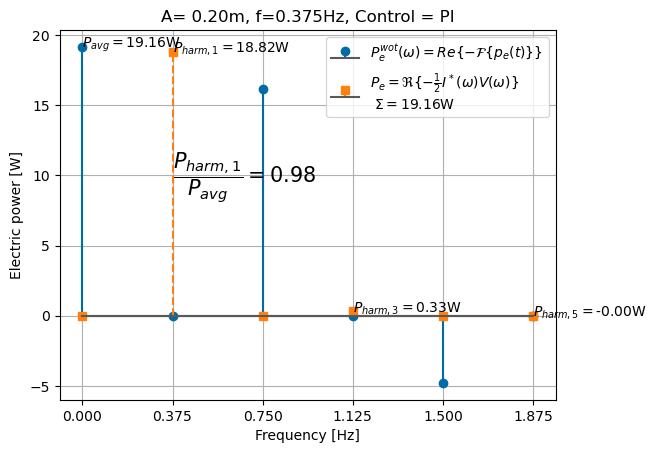

In [14]:
fig, ax = plt.subplots()
# ax.plot(pen_fdom.freq, Pe_wot, label = '$P_e^{wot}(\omega) = Re\{-\mathcal{F} \{ p_e(t) \}\}$' , marker = 'o')
ax.stem(pen_fdom.freq, Pe_wot, label = '$P_e^{wot}(\omega) = Re\{-\mathcal{F} \{ p_e(t) \}\}$' , markerfmt = 'C0o')

# ax.plot(pen_fdom.freq, epower_fd, label = r'$P_e = \Re\{-\frac{1}{2} I^*(\omega)V(\omega)\}$'+' \n $\Sigma=$' +f'{np.sum(epower_fd).values:.2f}W', marker = 'o')
ax.stem(pen_fdom.freq, epower_fd, label = r'$P_e = \Re\{-\frac{1}{2} I^*(\omega)V(\omega)\}$'+' \n $\Sigma=$' +f'{np.sum(epower_fd).values:.2f}W', markerfmt = 'C1s', linefmt=  'C1--')

ax.set_xticks(pen_fdom.freq)
ax.grid()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Electric power [W]')
ax.text(0, Pe_wot[0], r'$P_{avg}=$'+f'{Pe_wot[0].values.item():.2f}W')
# ax.text(wavefreq, epower_fd[1], r'$P_{fund}=$'+f'{epower_fd[1].values.item():.2f}W')
for n in ind_freqs[ind_freqs % 2 != 0]:
    ax.text(n*wavefreq, epower_fd[n], r'$P_{harm,'+f'{n}' +r'}=$'+f'{epower_fd[n].values.item():.2f}W')
ax.text(wavefreq, epower_fd[1]/2, r'$\dfrac{P_{harm,1}}{P_{avg}}=$'+f'{(epower_fd[1]/Pe_wot[0] ).values.item():.2f}', fontdict={'size': 15})
ax.legend()
ax.set_title(f'A= {amplitude:.2f}m, f={wavefreq}Hz, Control = {cntrl_type}')

Text(0, 0.5, 'Gen. torque (Nm)')

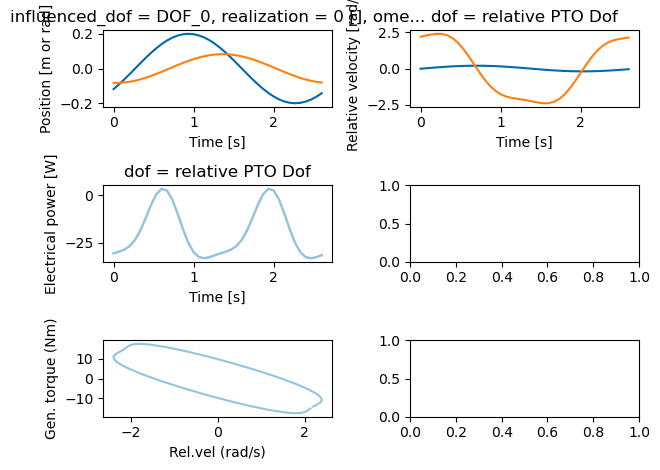

In [15]:
my_colors = plt.cm.Blues(np.linspace(0.4, 0.75, 1))

fig, axes = plt.subplots(3,2, tight_layout = True)

wec_tdom['wave_elev'].plot(ax = axes[0,0])
wec_tdom['pos'].plot(ax = axes[0,0])

wec_tdom['vel'].plot(ax = axes[0,1], label = 'Buoy vel')
pen_tdom['rel_vel'].plot(ax = axes[0,1], label = 'Pen vel')


pen_tdom['epower'].plot(ax = axes[1,0], color = my_colors[0])
pen_tdom['epower'].plot(ax = axes[1,0], color = my_colors[0])

axes[2,0].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'), color = my_colors[0])
axes[2,0].set_xlabel('Rel.vel (rad/s)')
axes[2,0].set_ylabel('Gen. torque (Nm)')

## 2D amplitude and wavefreq

In [16]:
# wave_freq_vec = [0.2, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.45, 0.5]
wave_freq_vec = [ 0.325,    0.4]

nfreq = 5
amplitude_vec = [0.05, 0.1]
cntrl_type = 'PI'

PI_pen_fdom_res_list = []
PI_spec_res_list = []
PI_Pavg_res_list = []

for amplitude in amplitude_vec:
    for wavefreq in wave_freq_vec:
        f1_reg = wavefreq
        waves_reg = wot.waves.regular_wave(f1_reg, nfreq, wavefreq, amplitude)
        NPIP = pip.NonlinearInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
        LinPIP = pip.LinearizedInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
        wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = LinPIP.f_add, constraints = LinPIP.constraints)  
        wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = NPIP.f_add, constraints = NPIP.constraints)
        try:
            res_lin = LinPIP.solve(wec_lin, waves_reg)
            x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)
            res_nl = NPIP.solve(wec_nl, waves_reg, x_wec_0, x_opt_0)
            nsubsteps = 5
            wec_fdom_list, wec_tdom_list, pen_fdom_list, pen_tdom_list = NPIP.post_process(wec_nl, res_nl, waves_reg, nsubsteps=nsubsteps)
            wec_fdom, wec_tdom, pen_fdom, pen_tdom = wec_fdom_list[0], wec_tdom_list[0], pen_fdom_list[0], pen_tdom_list[0]
            epower_fd = np.real(-(1/2)*np.conj(pen_fdom['quad_current'])*pen_fdom['back_emf'])
            Pe_wot = np.real(-1*pen_fdom['epower'])
            PI_Pavg_res_list.append(Pe_wot[0])
            PI_spec_res_list.append(epower_fd[1]/Pe_wot[0])
            PI_pen_fdom_res_list.append(pen_fdom)
        except:
            print(f"An exception occurred for A={amplitude}, f={wavefreq}, adding nan") 
            PI_Pavg_res_list.append(np.nan)
            PI_spec_res_list.append(np.nan)
            PI_pen_fdom_res_list.append(np.nan)


Linearized wave 0, exit mode: 0, nit: 44, cntr: PI, avg. power: -2.34W
NonLin wave 0, exit mode: 0, nit: 25, cntr: PI, avg. power: -4.40W
Linearized wave 0, exit mode: 0, nit: 29, cntr: PI, avg. power: -0.72W
NonLin wave 0, exit mode: 0, nit: 20, cntr: PI, avg. power: -0.49W
Linearized wave 0, exit mode: 0, nit: 34, cntr: PI, avg. power: -22.37W
NonLin wave 0, exit mode: 0, nit: 16, cntr: PI, avg. power: -15.64W
Linearized wave 0, exit mode: 0, nit: 24, cntr: PI, avg. power: -2.88W
NonLin wave 0, exit mode: 0, nit: 23, cntr: PI, avg. power: -2.15W


c:\Users\dtgaebe\AppData\Local\miniforge3\envs\wecopttool_dev\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\dtgaebe\AppData\Local\miniforge3\envs\wecopttool_dev\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


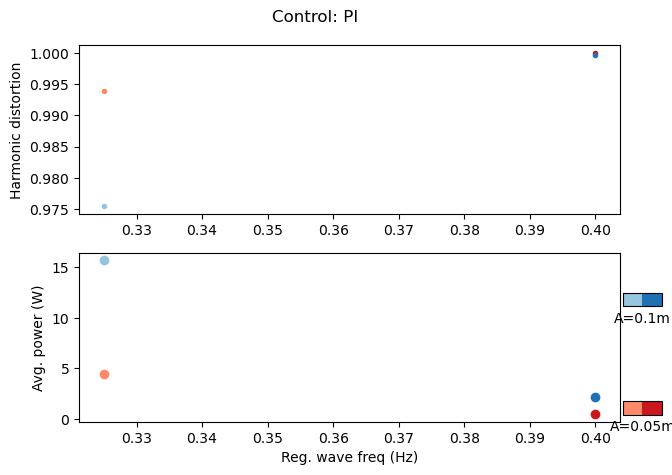

In [17]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable


my_blues = plt.cm.Blues(np.linspace(0.4, 0.75, len(wave_freq_vec)))
my_reds = plt.cm.Reds(np.linspace(0.4, 0.75, len(wave_freq_vec)))
color_mix = []
for n in np.arange(len(amplitude_vec)):
    ratio = n/(len(amplitude_vec)-1)
    color_mix.append(my_blues*ratio+my_reds*(1-ratio))

fig, axes = plt.subplots(2, 1, tight_layout=True)
fig.suptitle('Control: ' + cntrl_type)
Pavg_mat = np.zeros((len(amplitude_vec), len(wave_freq_vec)))
Rspec_mat = np.zeros((len(amplitude_vec), len(wave_freq_vec)))

# Loop through amplitudes and wave frequencies
for i, A in enumerate(amplitude_vec):
    for j, wf in enumerate(wave_freq_vec):
        idx = i * len(amplitude_vec) + j  # Calculate the correct index
        P_avg = PI_Pavg_res_list[idx]
        Rspec = PI_spec_res_list[idx]

        Pavg_mat[i,j] = P_avg
        Rspec_mat[i,j] = Rspec

        axes[0].plot(wf, Rspec, '.', color = color_mix[i][j])
        axes[1].plot(wf, P_avg, 'o', color = color_mix[i][j])



axes[1].set_xlabel('Reg. wave freq (Hz)')
axes[1].set_ylabel('Avg. power (W)')
axes[0].set_ylabel('Harmonic distortion')


for i, A in enumerate(amplitude_vec):
    sm = ScalarMappable(cmap=LinearSegmentedColormap.from_list(name = 'Custom', colors=color_mix[i], N=len(color_mix[i])))#, norm=norm)   
    cbar = fig.colorbar(sm, ax = axes, orientation='horizontal', shrink=0.08, aspect = 3, ticks = [], label = f'A={A}m', anchor = (1.2, 0.3+0.1*i))




Text(0.5, 0, 'Avg. power (W)')

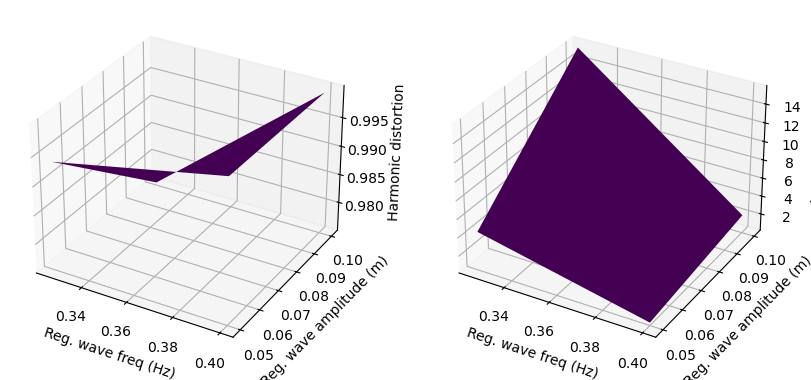

In [18]:
# Create a figure and subplots
fig = plt.figure(figsize=(10, 10))

# First subplot
ax1 = fig.add_subplot(2, 2, 1, projection='3d')


# X, Y = np.meshgrid(amplitude_vec, wave_freq_vec)
X, Y = np.meshgrid(wave_freq_vec, amplitude_vec)

# ax1.scatter(X, Y, P_mat, c= P_mat, cmap='viridis')
ax1.plot_surface(X, Y, Rspec_mat, cmap='viridis')

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Pavg_mat, cmap='viridis')

ax1.set_xlabel('Reg. wave freq (Hz)')
ax2.set_xlabel('Reg. wave freq (Hz)')

ax1.set_ylabel('Reg. wave amplitude (m)')
ax2.set_ylabel('Reg. wave amplitude (m)')

ax1.set_zlabel('Harmonic distortion')
ax2.set_zlabel('Avg. power (W)')
